# Face Generation

This notebook creates a Genrative Adversarial Network (GAN). The GAN is designed to produce realistic human faces after being trained on a large data set of human faces. Prior to this, it's functionality is tested by training on a database of handwriting sample and then producing realistic images of had-drawn alphanumeric characters.

### Loading the Relevant Packages
The packages used in this are [os](https://docs.python.org/3/library/os.html), [glob](https://docs.python.org/3/library/glob.html), [matplotlib](https://matplotlib.org/), [numpy](http://www.numpy.org/), [tqdm](https://pypi.python.org/pypi/tqdm), [warnings](https://docs.python.org/3.1/library/warnings.html), and [tensorflow](https://www.tensorflow.org/api_docs/python/)

helper and unittests are dependencies that should be included in the same directory as this Jupyter notebook.

Documentation for the packages is included in the hyperlinks.

In [ ]:
import os
import helper
import warnings

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import unittests as tests
from tqdm import tqdm
from glob import glob
from distutils.version import LooseVersion

### Get the Data
This GAN utilizes the MNIST and CelebA datasets. The MNIST data set is far simpler than the the celebA dataset. The MNIST is also black ans white instead of in RGB. Running the GAN on MNIST allows for testing of how well the model trains before moving onto the more complex data.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# If using FloydHub, use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

# If using Local data, use the /data subfolder 
data_dir = './data'

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Exploration and Preprocessing of the Data
The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images. The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single color channel while the CelebA images have 3 color channels.

### MNIST
The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits.

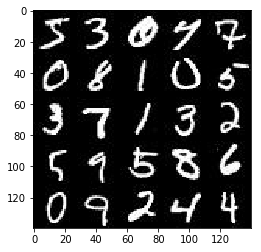

In [2]:
show_n_images = 25
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
plt.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is a dataset that contains over 202,599 celebrity images with annotations. For the purposes of generating new faces, the annotations are irrelevant.

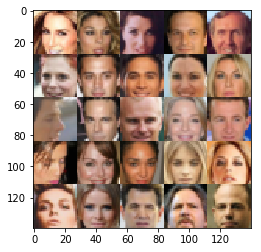

In [3]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
plt.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Building the Neural Network
The following functions defined below are used to build the neural network:
* model_inputs
* discriminator
* generator
* model_loss
* model_opt
* train

### Checking the Version of TensorFlow and Access to GPU

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Checks TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Checks for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train the neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


C:\Users\matth\Anaconda3\envs\dlnd\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
The function model_inputs() creates the model inputs. it returns a tuple of (tensor of real input images, tensor of z data, learning rate)
* image_width: The input image width
* image_height: The input image height
* z_dim: The dimension of Z

In [5]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    tensor_real_inputs = tf.placeholder(dtype = tf.float32, shape = (None, image_height, image_width, image_channels))
    tensor_z_data = tf.placeholder(dtype = tf.float32, shape = (None, z_dim))
    learning_rate = tf.placeholder(dtype = tf.float32, shape = ())

    return tensor_real_inputs, tensor_z_data, learning_rate

tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
The discriminator() function creates the discriminator network. It returns a tuple of the tensor output of the discriminator and the tensor logits of the discriminator.
* images: Tensor of input image(s)
* reuse: Boolean if the weights should be reused

In [6]:
def discriminator(images, reuse = False):
    with tf.variable_scope('discriminator', reuse = reuse):
        x = tf.layers.conv2d(images, filters = 32, 
                             kernel_size = 5, 
                             strides = 2,
                             padding='same', 
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        x = tf.maximum(0.2 * x, x)
        
        x = tf.layers.conv2d(images, filters = 64, 
                             kernel_size = 5, 
                             strides = 2,
                             padding='same', 
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(0.2 * x, x)
        x = tf.nn.dropout(x, keep_prob = 0.5)
        
        x = tf.layers.conv2d(x, filters = 128, 
                             kernel_size = 5, 
                             strides = 2,
                             padding = 'same', 
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(0.2 * x, x)
        x = tf.nn.dropout(x, keep_prob = 0.5)
        
        x = tf.layers.conv2d(x, filters = 256, 
                             kernel_size = 5, 
                             strides = 2,
                             padding = 'same', 
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(0.2 * x, x)
        
        flattened = tf.reshape(x, [-1, 2 * 2 * 256])
        logits = tf.layers.dense(flattened, 1, activation = None)
        output = tf.sigmoid(logits)

    return output, logits

tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
The generator() function creates the generator network. It returns the tensor output of the generator
* z: Input z
* out_channel_dim: The number of channels in the output image
* is_train: Boolean if generator is being used for training

In [7]:
def generator(z, out_channel_dim, is_train=True):
    
    with tf.variable_scope('generator', reuse = not is_train):
        x = tf.layers.dense(z, units = 4 * 4 * 512)
        x = tf.reshape(x, (-1, 4, 4, 512))
        x = tf.layers.batch_normalization(x, training = is_train)
        x = tf.maximum( 0.2 * x, x)
        
        x = tf.layers.conv2d_transpose(x, filters = 128, kernel_size = 4, strides = 1, padding = 'valid')
        x = tf.layers.batch_normalization(x, training = is_train)
        x = tf.maximum(0.2 * x, x)
        
        x = tf.layers.conv2d_transpose(x, filters = 64, kernel_size = 5, strides = 2, padding = 'same')
        x = tf.layers.batch_normalization(x, training = is_train)
        x = tf.maximum(0.2 * x, x)
        
        x = tf.layers.conv2d_transpose(x, filters = 32, kernel_size = 5, strides = 2, padding = 'same')
        x = tf.layers.batch_normalization(x, training = is_train)
        x = tf.maximum(0.2 * x, x)
        
        logits = tf.layers.conv2d_transpose(x, filters = out_channel_dim, kernel_size = 3, strides = 1,
                                            padding = 'same')
        out = tf.tanh(logits)
        print(out.get_shape())
        
    return out

tests.test_generator(generator, tf)

(?, 28, 28, 5)
(?, 28, 28, 5)
Tests Passed


### Loss
The function model_loss() gets the loss for the discriminator and generator. It returns a tuple of the discriminator loss and the generator loss.
* input_real: Images from the real dataset
* input_z: Z input
* out_channel_dim: The number of channels in the output image 

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    
    generator_model = generator(input_z, out_channel_dim, is_train = True)
    discriminator_model_real, discriminator_logits_real = discriminator(input_real, reuse = False)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse = True)
    
    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = discriminator_logits_real, labels = tf.ones_like(discriminator_model_real) * (1 - 0.1)))
    
    discriminator_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = discriminator_logits_fake, labels = tf.zeros_like(discriminator_model_fake)))
    
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = discriminator_logits_fake, labels = tf.ones_like(discriminator_model_fake)))
    
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    
    return discriminator_loss, generator_loss

tests.test_model_loss(model_loss)

(?, 28, 28, 4)
Tests Passed


### Optimization
The function model_opt() gets the optimization operations. it returns a tuple of the discriminator training operation and the generator training operation)
* d_loss: Discriminator loss Tensor
* g_loss: Generator loss Tensor
* learning_rate: Learning Rate Placeholder
* beta1: The exponential decay rate for the 1st moment in the optimizer

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    training_vars = tf.trainable_variables()
    discriminator_vars = [var for var in training_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in training_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    discriminator_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    generator_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(discriminator_updates):
        discriminator_opt = tf.train.AdamOptimizer(
            learning_rate = learning_rate, beta1 = beta1).minimize(d_loss, var_list = discriminator_vars)

    with tf.control_dependencies(generator_updates):
        generator_opt = tf.train.AdamOptimizer(
            learning_rate = learning_rate, beta1 = beta1).minimize(g_loss, var_list = generator_vars)
            
    return discriminator_opt, generator_opt

tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Showing Generator Output
The show_generator_output() function shows an example output for the generator.
* sess: TensorFlow session
* n_images: Number of Images to display
* input_z: Input Z Tensor
* out_channel_dim: The number of channels in the output image
* image_mode: The mode to use for images ("RGB" or "L")

In [10]:
def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    plt.imshow(images_grid, cmap=cmap)
    plt.show()

### Building and Training GANs
The train() function trains the GAN.
* epoch_count: Number of epochs
* batch_size: Batch Size
* z_dim: Z dimension
* learning_rate: Learning Rate
* beta1: The exponential decay rate for the 1st moment in the optimizer
* get_batches: Function to get batches
* data_shape: Shape of the data
* data_image_mode: The image mode to use for images ("RGB" or "L")

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    n_samples, width, height, channels = data_shape
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    discriminator_loss, generator_loss = model_loss(input_real, input_z, channels)
    discriminator_train_opt, generator_train_opt = model_opt(discriminator_loss, generator_loss, lr, beta1)
    print(data_shape)
    
    i = 0    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # DONE: Train Model             
                batch_images = batch_images * 2.0
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                sess.run(discriminator_train_opt, feed_dict = {input_real: batch_images,
                                                               input_z: batch_z,
                                                               lr: learning_rate})
                sess.run(generator_train_opt, feed_dict = {input_real: batch_images,
                                                           input_z: batch_z,
                                                           lr: learning_rate})
                
                i += 1
                if i % 10 == 0:
                    train_loss_discriminator = discriminator_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_generator = generator_loss.eval({input_z: batch_z})
                    print('Epoch %d/%d Discriminator loss %.4f Generator loss %.4f' % (epoch_i + 1,
                                                                                       epoch_count,
                                                                                       train_loss_discriminator,
                                                                                       train_loss_generator))
                if i % 100 == 0:
                    show_generator_output(sess, 50, input_z, channels, data_image_mode)
                
                

### Testing GAN Architecture on MNIST

(?, 28, 28, 1)
(60000, 28, 28, 1)
Epoch 1/2 Discriminator loss 1.7700 Generator loss 2.9326
Epoch 1/2 Discriminator loss 1.6047 Generator loss 2.2482
Epoch 1/2 Discriminator loss 1.5954 Generator loss 1.6577
Epoch 1/2 Discriminator loss 1.6201 Generator loss 1.3405
Epoch 1/2 Discriminator loss 1.6325 Generator loss 0.5668
Epoch 1/2 Discriminator loss 1.3510 Generator loss 0.8071
Epoch 1/2 Discriminator loss 1.6094 Generator loss 0.9204
Epoch 1/2 Discriminator loss 1.4125 Generator loss 1.1725
Epoch 1/2 Discriminator loss 1.4980 Generator loss 1.1410
Epoch 1/2 Discriminator loss 1.4610 Generator loss 0.9008
(?, 28, 28, 1)


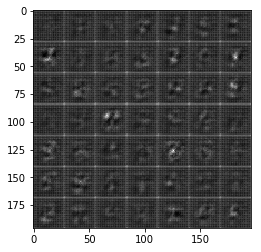

Epoch 1/2 Discriminator loss 1.3587 Generator loss 0.7756
Epoch 1/2 Discriminator loss 1.3978 Generator loss 1.0620
Epoch 1/2 Discriminator loss 1.4280 Generator loss 0.9754
Epoch 1/2 Discriminator loss 1.4081 Generator loss 1.0497
Epoch 1/2 Discriminator loss 1.3830 Generator loss 1.0566
Epoch 1/2 Discriminator loss 1.3903 Generator loss 0.8581
Epoch 1/2 Discriminator loss 1.3769 Generator loss 1.0886
Epoch 1/2 Discriminator loss 1.3534 Generator loss 0.9587
Epoch 1/2 Discriminator loss 1.3362 Generator loss 1.0479
Epoch 1/2 Discriminator loss 1.3367 Generator loss 1.1000
(?, 28, 28, 1)


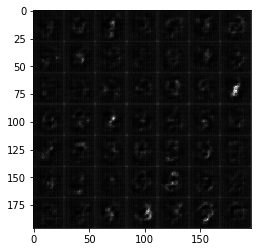

Epoch 1/2 Discriminator loss 1.3211 Generator loss 1.0253
Epoch 1/2 Discriminator loss 1.3543 Generator loss 0.7339
Epoch 1/2 Discriminator loss 1.3796 Generator loss 0.6245
Epoch 1/2 Discriminator loss 1.3582 Generator loss 0.7269
Epoch 1/2 Discriminator loss 1.2492 Generator loss 0.9870
Epoch 1/2 Discriminator loss 1.3100 Generator loss 1.1569
Epoch 1/2 Discriminator loss 1.3830 Generator loss 1.1729
Epoch 1/2 Discriminator loss 1.3675 Generator loss 0.9992
Epoch 1/2 Discriminator loss 1.3952 Generator loss 0.7132
Epoch 1/2 Discriminator loss 1.3315 Generator loss 0.7405
(?, 28, 28, 1)


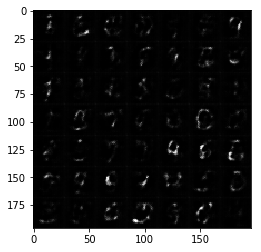

Epoch 1/2 Discriminator loss 1.3909 Generator loss 1.0263
Epoch 1/2 Discriminator loss 1.3659 Generator loss 1.0408
Epoch 1/2 Discriminator loss 1.3526 Generator loss 0.8845
Epoch 1/2 Discriminator loss 1.3700 Generator loss 0.7034
Epoch 1/2 Discriminator loss 1.3289 Generator loss 0.7369
Epoch 1/2 Discriminator loss 1.3612 Generator loss 0.6506
Epoch 1/2 Discriminator loss 1.3237 Generator loss 0.7259
Epoch 1/2 Discriminator loss 1.3036 Generator loss 0.7049
Epoch 1/2 Discriminator loss 1.4439 Generator loss 0.6777
Epoch 1/2 Discriminator loss 1.3784 Generator loss 0.7405
(?, 28, 28, 1)


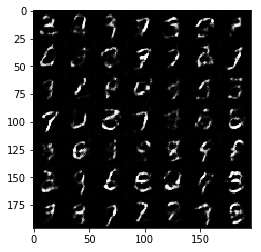

Epoch 1/2 Discriminator loss 1.3470 Generator loss 0.8432
Epoch 1/2 Discriminator loss 1.3565 Generator loss 0.8832
Epoch 1/2 Discriminator loss 1.3475 Generator loss 1.0667
Epoch 1/2 Discriminator loss 1.3544 Generator loss 0.8304
Epoch 1/2 Discriminator loss 1.2821 Generator loss 0.8374
Epoch 1/2 Discriminator loss 1.3881 Generator loss 1.0042
Epoch 1/2 Discriminator loss 1.3632 Generator loss 1.0332
Epoch 1/2 Discriminator loss 1.3346 Generator loss 0.7565
Epoch 1/2 Discriminator loss 1.3758 Generator loss 0.8156
Epoch 1/2 Discriminator loss 1.3484 Generator loss 0.9736
(?, 28, 28, 1)


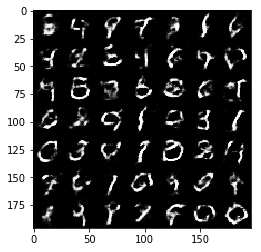

Epoch 1/2 Discriminator loss 1.3599 Generator loss 0.8425
Epoch 1/2 Discriminator loss 1.4044 Generator loss 0.7515
Epoch 1/2 Discriminator loss 1.3876 Generator loss 1.0128
Epoch 1/2 Discriminator loss 1.3331 Generator loss 0.9387
Epoch 1/2 Discriminator loss 1.3676 Generator loss 0.7891
Epoch 1/2 Discriminator loss 1.3585 Generator loss 0.7844
Epoch 1/2 Discriminator loss 1.5002 Generator loss 0.5713
Epoch 1/2 Discriminator loss 1.3435 Generator loss 0.7696
Epoch 1/2 Discriminator loss 1.3579 Generator loss 0.8609
Epoch 1/2 Discriminator loss 1.3506 Generator loss 0.7147
(?, 28, 28, 1)


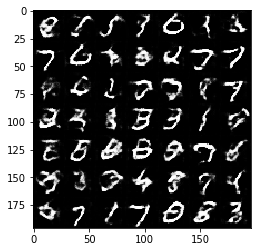

Epoch 1/2 Discriminator loss 1.2951 Generator loss 0.8101
Epoch 1/2 Discriminator loss 1.3930 Generator loss 0.7188
Epoch 1/2 Discriminator loss 1.3544 Generator loss 0.7332
Epoch 1/2 Discriminator loss 1.3754 Generator loss 0.9137
Epoch 1/2 Discriminator loss 1.3805 Generator loss 0.8453
Epoch 1/2 Discriminator loss 1.3304 Generator loss 0.7897
Epoch 1/2 Discriminator loss 1.3406 Generator loss 0.7322
Epoch 1/2 Discriminator loss 1.3761 Generator loss 0.8176
Epoch 1/2 Discriminator loss 1.3317 Generator loss 0.7639
Epoch 1/2 Discriminator loss 1.3541 Generator loss 0.6873
(?, 28, 28, 1)


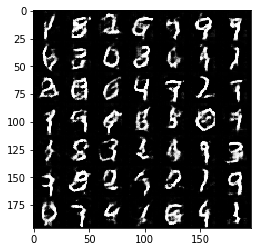

Epoch 1/2 Discriminator loss 1.3050 Generator loss 0.9204
Epoch 1/2 Discriminator loss 1.3855 Generator loss 0.9313
Epoch 1/2 Discriminator loss 1.3614 Generator loss 0.8052
Epoch 1/2 Discriminator loss 1.3024 Generator loss 0.7217
Epoch 1/2 Discriminator loss 1.2895 Generator loss 0.8021
Epoch 1/2 Discriminator loss 1.3378 Generator loss 0.7965
Epoch 1/2 Discriminator loss 1.3281 Generator loss 0.6772
Epoch 1/2 Discriminator loss 1.3608 Generator loss 0.6883
Epoch 1/2 Discriminator loss 1.3894 Generator loss 0.7109
Epoch 1/2 Discriminator loss 1.3553 Generator loss 0.7480
(?, 28, 28, 1)


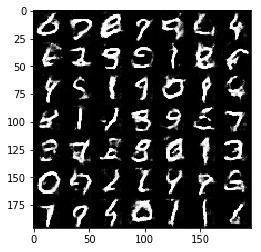

Epoch 1/2 Discriminator loss 1.2989 Generator loss 0.8061
Epoch 1/2 Discriminator loss 1.3203 Generator loss 0.8120
Epoch 1/2 Discriminator loss 1.3355 Generator loss 0.8837
Epoch 1/2 Discriminator loss 1.3492 Generator loss 1.1503
Epoch 1/2 Discriminator loss 1.2732 Generator loss 0.9300
Epoch 1/2 Discriminator loss 1.2893 Generator loss 0.8418
Epoch 1/2 Discriminator loss 1.3645 Generator loss 0.6986
Epoch 1/2 Discriminator loss 1.3142 Generator loss 0.7933
Epoch 1/2 Discriminator loss 1.3874 Generator loss 0.8599
Epoch 1/2 Discriminator loss 1.3096 Generator loss 1.1536
(?, 28, 28, 1)


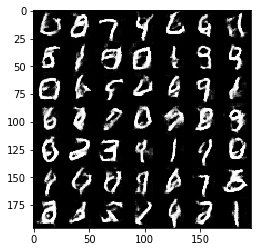

Epoch 1/2 Discriminator loss 1.3580 Generator loss 0.8784
Epoch 1/2 Discriminator loss 1.2966 Generator loss 0.8850
Epoch 1/2 Discriminator loss 1.3960 Generator loss 1.0337
Epoch 2/2 Discriminator loss 1.3298 Generator loss 0.6966
Epoch 2/2 Discriminator loss 1.3367 Generator loss 0.8496
Epoch 2/2 Discriminator loss 1.2999 Generator loss 0.8810
Epoch 2/2 Discriminator loss 1.3529 Generator loss 0.7428
Epoch 2/2 Discriminator loss 1.3414 Generator loss 0.9101
Epoch 2/2 Discriminator loss 1.3564 Generator loss 0.8724
Epoch 2/2 Discriminator loss 1.3858 Generator loss 0.9838
(?, 28, 28, 1)


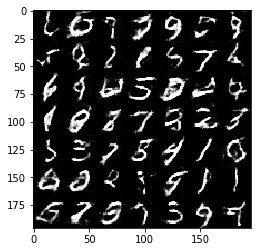

Epoch 2/2 Discriminator loss 1.3376 Generator loss 0.7650
Epoch 2/2 Discriminator loss 1.3915 Generator loss 0.9973
Epoch 2/2 Discriminator loss 1.3185 Generator loss 1.0293
Epoch 2/2 Discriminator loss 1.3897 Generator loss 0.8736
Epoch 2/2 Discriminator loss 1.3248 Generator loss 1.0494
Epoch 2/2 Discriminator loss 1.3332 Generator loss 0.8166
Epoch 2/2 Discriminator loss 1.3477 Generator loss 0.6695
Epoch 2/2 Discriminator loss 1.3169 Generator loss 0.7744
Epoch 2/2 Discriminator loss 1.3576 Generator loss 0.9313
Epoch 2/2 Discriminator loss 1.3995 Generator loss 0.9030
(?, 28, 28, 1)


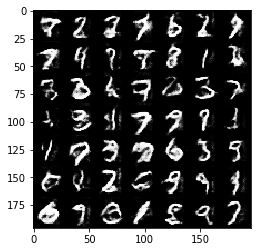

Epoch 2/2 Discriminator loss 1.2579 Generator loss 0.8007
Epoch 2/2 Discriminator loss 1.3390 Generator loss 0.7092
Epoch 2/2 Discriminator loss 1.2672 Generator loss 0.8572
Epoch 2/2 Discriminator loss 1.3612 Generator loss 0.7782
Epoch 2/2 Discriminator loss 1.3361 Generator loss 0.9428
Epoch 2/2 Discriminator loss 1.3793 Generator loss 0.9735
Epoch 2/2 Discriminator loss 1.2606 Generator loss 0.8697
Epoch 2/2 Discriminator loss 1.3588 Generator loss 0.7912
Epoch 2/2 Discriminator loss 1.4266 Generator loss 0.6548
Epoch 2/2 Discriminator loss 1.3226 Generator loss 0.8141
(?, 28, 28, 1)


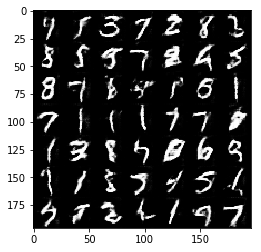

Epoch 2/2 Discriminator loss 1.2975 Generator loss 0.8523
Epoch 2/2 Discriminator loss 1.3071 Generator loss 0.8040
Epoch 2/2 Discriminator loss 1.3432 Generator loss 0.6458
Epoch 2/2 Discriminator loss 1.3572 Generator loss 0.7705
Epoch 2/2 Discriminator loss 1.3299 Generator loss 0.8034
Epoch 2/2 Discriminator loss 1.3645 Generator loss 0.6673
Epoch 2/2 Discriminator loss 1.3404 Generator loss 0.7176
Epoch 2/2 Discriminator loss 1.2970 Generator loss 0.7264
Epoch 2/2 Discriminator loss 1.2445 Generator loss 0.7918
Epoch 2/2 Discriminator loss 1.3522 Generator loss 0.9129
(?, 28, 28, 1)


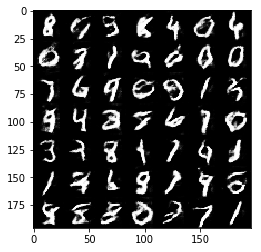

Epoch 2/2 Discriminator loss 1.2882 Generator loss 0.9837
Epoch 2/2 Discriminator loss 1.3358 Generator loss 0.9075
Epoch 2/2 Discriminator loss 1.3548 Generator loss 1.1419
Epoch 2/2 Discriminator loss 1.2393 Generator loss 0.8435
Epoch 2/2 Discriminator loss 1.4151 Generator loss 0.6532
Epoch 2/2 Discriminator loss 1.4113 Generator loss 0.5880
Epoch 2/2 Discriminator loss 1.2649 Generator loss 0.8766
Epoch 2/2 Discriminator loss 1.3097 Generator loss 0.7982
Epoch 2/2 Discriminator loss 1.3343 Generator loss 0.6437
Epoch 2/2 Discriminator loss 1.3680 Generator loss 1.1050
(?, 28, 28, 1)


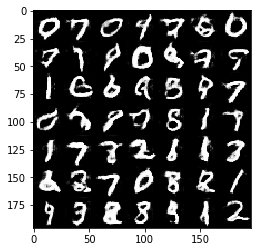

Epoch 2/2 Discriminator loss 1.3339 Generator loss 0.8410
Epoch 2/2 Discriminator loss 1.3354 Generator loss 0.8550
Epoch 2/2 Discriminator loss 1.3325 Generator loss 0.8079
Epoch 2/2 Discriminator loss 1.3063 Generator loss 1.0742
Epoch 2/2 Discriminator loss 1.3420 Generator loss 0.8399
Epoch 2/2 Discriminator loss 1.3745 Generator loss 0.9710
Epoch 2/2 Discriminator loss 1.3168 Generator loss 0.9732
Epoch 2/2 Discriminator loss 1.3896 Generator loss 0.7865
Epoch 2/2 Discriminator loss 1.3521 Generator loss 1.1712
Epoch 2/2 Discriminator loss 1.3389 Generator loss 0.8585
(?, 28, 28, 1)


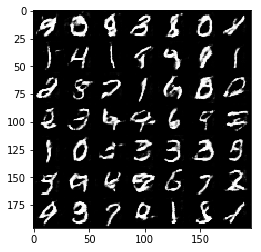

Epoch 2/2 Discriminator loss 1.3217 Generator loss 0.8621
Epoch 2/2 Discriminator loss 1.3375 Generator loss 1.0288
Epoch 2/2 Discriminator loss 1.2531 Generator loss 0.9425
Epoch 2/2 Discriminator loss 1.2634 Generator loss 0.9051
Epoch 2/2 Discriminator loss 1.3150 Generator loss 0.7427
Epoch 2/2 Discriminator loss 1.3382 Generator loss 0.7265
Epoch 2/2 Discriminator loss 1.3575 Generator loss 0.6869
Epoch 2/2 Discriminator loss 1.3850 Generator loss 0.7477
Epoch 2/2 Discriminator loss 1.3352 Generator loss 0.8874
Epoch 2/2 Discriminator loss 1.3200 Generator loss 0.9306
(?, 28, 28, 1)


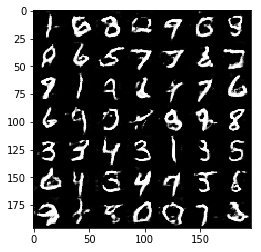

Epoch 2/2 Discriminator loss 1.3156 Generator loss 0.8434
Epoch 2/2 Discriminator loss 1.2854 Generator loss 0.9159
Epoch 2/2 Discriminator loss 1.3343 Generator loss 0.9858
Epoch 2/2 Discriminator loss 1.3233 Generator loss 0.8839
Epoch 2/2 Discriminator loss 1.3294 Generator loss 0.8366
Epoch 2/2 Discriminator loss 1.3014 Generator loss 0.8344
Epoch 2/2 Discriminator loss 1.3089 Generator loss 0.8682
Epoch 2/2 Discriminator loss 1.3010 Generator loss 0.8781
Epoch 2/2 Discriminator loss 1.2986 Generator loss 0.7118
Epoch 2/2 Discriminator loss 1.3559 Generator loss 0.6664
(?, 28, 28, 1)


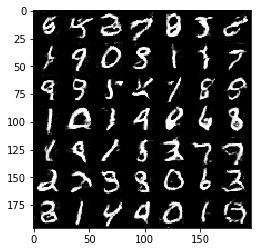

Epoch 2/2 Discriminator loss 1.3780 Generator loss 0.6215
Epoch 2/2 Discriminator loss 1.3297 Generator loss 0.8293
Epoch 2/2 Discriminator loss 1.4141 Generator loss 0.7361
Epoch 2/2 Discriminator loss 1.3234 Generator loss 0.7295
Epoch 2/2 Discriminator loss 1.2828 Generator loss 0.8464
Epoch 2/2 Discriminator loss 1.2340 Generator loss 1.0284
Epoch 2/2 Discriminator loss 1.2595 Generator loss 0.8185
Epoch 2/2 Discriminator loss 1.3314 Generator loss 0.6746
Epoch 2/2 Discriminator loss 1.2502 Generator loss 0.7155
Epoch 2/2 Discriminator loss 1.3770 Generator loss 0.8699
(?, 28, 28, 1)


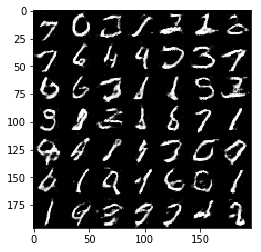

Epoch 2/2 Discriminator loss 1.3328 Generator loss 0.8290
Epoch 2/2 Discriminator loss 1.4020 Generator loss 0.7314
Epoch 2/2 Discriminator loss 1.3654 Generator loss 0.7031
Epoch 2/2 Discriminator loss 1.3216 Generator loss 0.7781
Epoch 2/2 Discriminator loss 1.3732 Generator loss 0.9847
Epoch 2/2 Discriminator loss 1.3682 Generator loss 0.8403
Epoch 2/2 Discriminator loss 1.2765 Generator loss 0.7715


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.1
epochs = 2

# After 2 epochs, the GANs are usually able to generate images that look like handwritten digits.
# When running, make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### Running GANs on CelebA

(?, 28, 28, 3)
(202599, 28, 28, 3)
Epoch 1/1 Discriminator loss 1.1141 Generator loss 1.1063
Epoch 1/1 Discriminator loss 0.6588 Generator loss 1.8166
Epoch 1/1 Discriminator loss 0.6198 Generator loss 2.3508
Epoch 1/1 Discriminator loss 0.5849 Generator loss 2.4049
Epoch 1/1 Discriminator loss 0.5428 Generator loss 3.0987
Epoch 1/1 Discriminator loss 0.5379 Generator loss 3.2581
Epoch 1/1 Discriminator loss 0.5105 Generator loss 3.2698
Epoch 1/1 Discriminator loss 0.4250 Generator loss 4.7478
Epoch 1/1 Discriminator loss 0.6538 Generator loss 2.8589
Epoch 1/1 Discriminator loss 0.7560 Generator loss 1.9850
(?, 28, 28, 3)


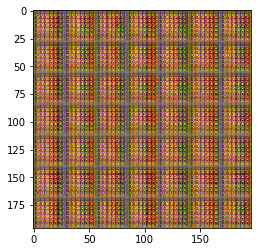

Epoch 1/1 Discriminator loss 0.6807 Generator loss 2.7514
Epoch 1/1 Discriminator loss 0.5847 Generator loss 3.0198
Epoch 1/1 Discriminator loss 0.6919 Generator loss 2.4979
Epoch 1/1 Discriminator loss 0.5255 Generator loss 3.4572
Epoch 1/1 Discriminator loss 0.6773 Generator loss 1.7698
Epoch 1/1 Discriminator loss 0.8368 Generator loss 4.0825
Epoch 1/1 Discriminator loss 0.6355 Generator loss 2.2512
Epoch 1/1 Discriminator loss 0.6414 Generator loss 3.1683
Epoch 1/1 Discriminator loss 0.5810 Generator loss 2.0193
Epoch 1/1 Discriminator loss 0.6742 Generator loss 2.3018
(?, 28, 28, 3)


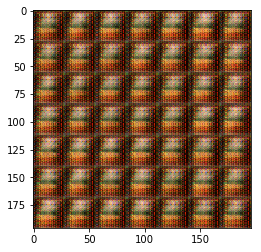

Epoch 1/1 Discriminator loss 0.6448 Generator loss 3.4048
Epoch 1/1 Discriminator loss 0.5478 Generator loss 2.7448
Epoch 1/1 Discriminator loss 0.5043 Generator loss 3.1915
Epoch 1/1 Discriminator loss 0.6069 Generator loss 2.3044
Epoch 1/1 Discriminator loss 0.4529 Generator loss 3.6211
Epoch 1/1 Discriminator loss 0.4995 Generator loss 2.7995
Epoch 1/1 Discriminator loss 0.5298 Generator loss 2.8580
Epoch 1/1 Discriminator loss 0.6509 Generator loss 2.2021
Epoch 1/1 Discriminator loss 0.6021 Generator loss 2.0943
Epoch 1/1 Discriminator loss 0.5007 Generator loss 2.9178
(?, 28, 28, 3)


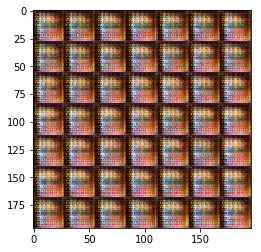

Epoch 1/1 Discriminator loss 0.6397 Generator loss 2.4238
Epoch 1/1 Discriminator loss 0.5463 Generator loss 2.9677
Epoch 1/1 Discriminator loss 0.5191 Generator loss 2.4903
Epoch 1/1 Discriminator loss 0.4416 Generator loss 3.3958
Epoch 1/1 Discriminator loss 0.5566 Generator loss 2.0886
Epoch 1/1 Discriminator loss 0.4981 Generator loss 3.3570
Epoch 1/1 Discriminator loss 0.5871 Generator loss 2.2915
Epoch 1/1 Discriminator loss 0.6877 Generator loss 2.7821
Epoch 1/1 Discriminator loss 0.5727 Generator loss 2.4691
Epoch 1/1 Discriminator loss 0.6732 Generator loss 2.3883
(?, 28, 28, 3)


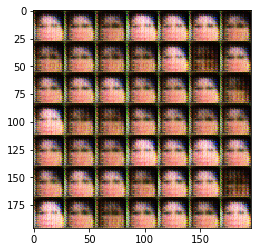

Epoch 1/1 Discriminator loss 0.6790 Generator loss 2.0534
Epoch 1/1 Discriminator loss 0.7260 Generator loss 1.7765
Epoch 1/1 Discriminator loss 1.5085 Generator loss 0.5190
Epoch 1/1 Discriminator loss 0.8284 Generator loss 1.7579
Epoch 1/1 Discriminator loss 0.8215 Generator loss 1.9242
Epoch 1/1 Discriminator loss 0.7391 Generator loss 1.5715
Epoch 1/1 Discriminator loss 0.5523 Generator loss 2.9556
Epoch 1/1 Discriminator loss 0.7621 Generator loss 2.1608
Epoch 1/1 Discriminator loss 0.7050 Generator loss 2.3176
Epoch 1/1 Discriminator loss 0.6842 Generator loss 1.9944
(?, 28, 28, 3)


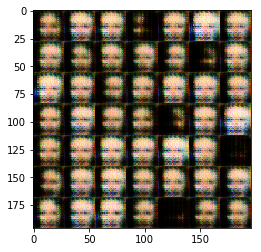

Epoch 1/1 Discriminator loss 1.0430 Generator loss 1.4236
Epoch 1/1 Discriminator loss 0.6734 Generator loss 1.8415
Epoch 1/1 Discriminator loss 0.9451 Generator loss 1.3810
Epoch 1/1 Discriminator loss 0.7821 Generator loss 1.9229
Epoch 1/1 Discriminator loss 0.5963 Generator loss 2.4030
Epoch 1/1 Discriminator loss 1.3984 Generator loss 1.5760
Epoch 1/1 Discriminator loss 1.0438 Generator loss 1.2305
Epoch 1/1 Discriminator loss 0.7316 Generator loss 1.6142
Epoch 1/1 Discriminator loss 1.4871 Generator loss 2.8107
Epoch 1/1 Discriminator loss 0.8392 Generator loss 1.7940
(?, 28, 28, 3)


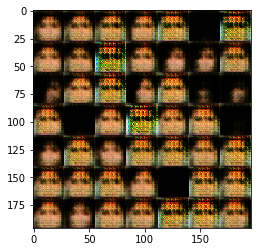

Epoch 1/1 Discriminator loss 0.8031 Generator loss 2.0322
Epoch 1/1 Discriminator loss 1.0848 Generator loss 1.8386
Epoch 1/1 Discriminator loss 0.9987 Generator loss 1.4611
Epoch 1/1 Discriminator loss 0.9939 Generator loss 1.5921
Epoch 1/1 Discriminator loss 0.9192 Generator loss 1.4785
Epoch 1/1 Discriminator loss 0.9032 Generator loss 1.4511
Epoch 1/1 Discriminator loss 0.8570 Generator loss 1.4303
Epoch 1/1 Discriminator loss 1.0952 Generator loss 0.9521
Epoch 1/1 Discriminator loss 1.1681 Generator loss 1.3395
Epoch 1/1 Discriminator loss 0.9246 Generator loss 1.9361
(?, 28, 28, 3)


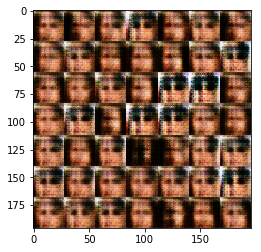

Epoch 1/1 Discriminator loss 0.8833 Generator loss 1.8427
Epoch 1/1 Discriminator loss 1.1002 Generator loss 1.2041
Epoch 1/1 Discriminator loss 0.8382 Generator loss 1.5231
Epoch 1/1 Discriminator loss 0.9965 Generator loss 1.2610
Epoch 1/1 Discriminator loss 0.8173 Generator loss 1.5003
Epoch 1/1 Discriminator loss 0.9280 Generator loss 1.5186
Epoch 1/1 Discriminator loss 0.8720 Generator loss 1.7572
Epoch 1/1 Discriminator loss 0.7026 Generator loss 1.8533
Epoch 1/1 Discriminator loss 0.8898 Generator loss 2.2293
Epoch 1/1 Discriminator loss 0.6895 Generator loss 1.9489
(?, 28, 28, 3)


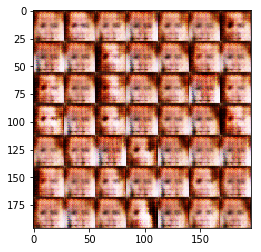

Epoch 1/1 Discriminator loss 0.9078 Generator loss 1.5623
Epoch 1/1 Discriminator loss 0.7849 Generator loss 1.5524
Epoch 1/1 Discriminator loss 0.7959 Generator loss 1.8225
Epoch 1/1 Discriminator loss 1.4432 Generator loss 0.9980
Epoch 1/1 Discriminator loss 1.4237 Generator loss 2.2000
Epoch 1/1 Discriminator loss 0.8155 Generator loss 1.4881
Epoch 1/1 Discriminator loss 0.9755 Generator loss 1.8312
Epoch 1/1 Discriminator loss 1.4749 Generator loss 0.5695
Epoch 1/1 Discriminator loss 1.0241 Generator loss 1.3976
Epoch 1/1 Discriminator loss 1.1729 Generator loss 1.2195
(?, 28, 28, 3)


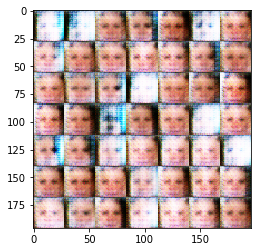

Epoch 1/1 Discriminator loss 0.7019 Generator loss 1.4387
Epoch 1/1 Discriminator loss 0.9926 Generator loss 1.2940
Epoch 1/1 Discriminator loss 1.1121 Generator loss 1.0981
Epoch 1/1 Discriminator loss 1.3675 Generator loss 1.3040
Epoch 1/1 Discriminator loss 1.1806 Generator loss 0.8706
Epoch 1/1 Discriminator loss 1.3327 Generator loss 0.8220
Epoch 1/1 Discriminator loss 0.9778 Generator loss 1.5156
Epoch 1/1 Discriminator loss 0.9513 Generator loss 1.6547
Epoch 1/1 Discriminator loss 0.7712 Generator loss 1.2897
Epoch 1/1 Discriminator loss 1.0025 Generator loss 1.2159
(?, 28, 28, 3)


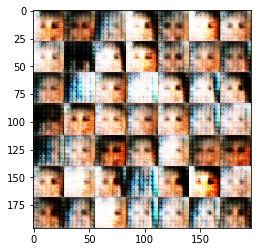

Epoch 1/1 Discriminator loss 1.0345 Generator loss 1.2041
Epoch 1/1 Discriminator loss 1.1023 Generator loss 1.3915
Epoch 1/1 Discriminator loss 0.9855 Generator loss 1.5537
Epoch 1/1 Discriminator loss 0.9388 Generator loss 1.2089
Epoch 1/1 Discriminator loss 0.8313 Generator loss 1.4146
Epoch 1/1 Discriminator loss 1.0382 Generator loss 1.0282
Epoch 1/1 Discriminator loss 1.1907 Generator loss 1.1949
Epoch 1/1 Discriminator loss 1.0634 Generator loss 1.6557
Epoch 1/1 Discriminator loss 0.9207 Generator loss 1.4158
Epoch 1/1 Discriminator loss 1.1009 Generator loss 1.1177
(?, 28, 28, 3)


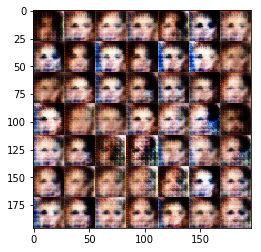

Epoch 1/1 Discriminator loss 1.0246 Generator loss 1.3595
Epoch 1/1 Discriminator loss 1.2918 Generator loss 1.8755
Epoch 1/1 Discriminator loss 1.6905 Generator loss 0.7069
Epoch 1/1 Discriminator loss 1.2638 Generator loss 1.1814
Epoch 1/1 Discriminator loss 0.9209 Generator loss 1.3436
Epoch 1/1 Discriminator loss 1.1121 Generator loss 1.1626
Epoch 1/1 Discriminator loss 1.1033 Generator loss 0.9917
Epoch 1/1 Discriminator loss 1.0122 Generator loss 1.4586
Epoch 1/1 Discriminator loss 1.1629 Generator loss 0.8439
Epoch 1/1 Discriminator loss 1.0653 Generator loss 1.6474
(?, 28, 28, 3)


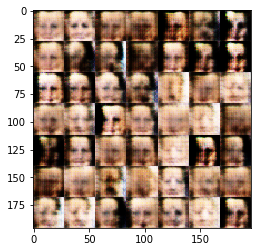

Epoch 1/1 Discriminator loss 0.8022 Generator loss 1.6223
Epoch 1/1 Discriminator loss 0.8078 Generator loss 1.3516
Epoch 1/1 Discriminator loss 1.0533 Generator loss 1.1283
Epoch 1/1 Discriminator loss 0.7065 Generator loss 1.7548
Epoch 1/1 Discriminator loss 1.5154 Generator loss 0.9754
Epoch 1/1 Discriminator loss 1.0813 Generator loss 1.3990
Epoch 1/1 Discriminator loss 0.9774 Generator loss 1.6582
Epoch 1/1 Discriminator loss 1.0231 Generator loss 1.1811
Epoch 1/1 Discriminator loss 1.3725 Generator loss 0.9134
Epoch 1/1 Discriminator loss 1.2241 Generator loss 0.9070
(?, 28, 28, 3)


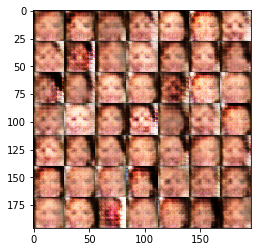

Epoch 1/1 Discriminator loss 1.3414 Generator loss 1.1108
Epoch 1/1 Discriminator loss 1.2595 Generator loss 1.0396
Epoch 1/1 Discriminator loss 1.1795 Generator loss 1.0634
Epoch 1/1 Discriminator loss 1.2244 Generator loss 1.3695
Epoch 1/1 Discriminator loss 1.3672 Generator loss 0.9811
Epoch 1/1 Discriminator loss 1.2304 Generator loss 1.1568
Epoch 1/1 Discriminator loss 1.2152 Generator loss 1.1756
Epoch 1/1 Discriminator loss 1.0266 Generator loss 1.1893
Epoch 1/1 Discriminator loss 1.2330 Generator loss 1.6497
Epoch 1/1 Discriminator loss 1.2311 Generator loss 0.9693
(?, 28, 28, 3)


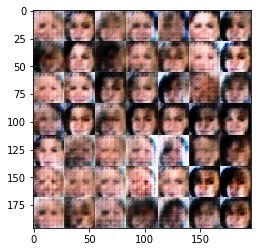

Epoch 1/1 Discriminator loss 1.4401 Generator loss 0.7608
Epoch 1/1 Discriminator loss 1.3393 Generator loss 1.1373
Epoch 1/1 Discriminator loss 1.2251 Generator loss 1.2061
Epoch 1/1 Discriminator loss 1.2898 Generator loss 1.1256
Epoch 1/1 Discriminator loss 1.0170 Generator loss 1.7228
Epoch 1/1 Discriminator loss 1.2752 Generator loss 1.0782
Epoch 1/1 Discriminator loss 1.0371 Generator loss 1.4461
Epoch 1/1 Discriminator loss 1.0754 Generator loss 1.1991
Epoch 1/1 Discriminator loss 1.0679 Generator loss 1.1643
Epoch 1/1 Discriminator loss 1.3904 Generator loss 0.9260
(?, 28, 28, 3)


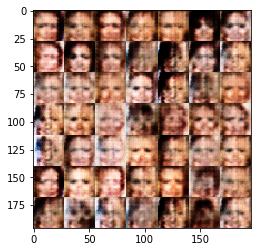

Epoch 1/1 Discriminator loss 1.1180 Generator loss 0.9146
Epoch 1/1 Discriminator loss 1.2421 Generator loss 1.2004
Epoch 1/1 Discriminator loss 1.2836 Generator loss 0.9608
Epoch 1/1 Discriminator loss 1.2363 Generator loss 0.8949
Epoch 1/1 Discriminator loss 1.2372 Generator loss 1.2535
Epoch 1/1 Discriminator loss 0.9870 Generator loss 1.2148
Epoch 1/1 Discriminator loss 1.2022 Generator loss 1.0648
Epoch 1/1 Discriminator loss 1.1115 Generator loss 0.9952
Epoch 1/1 Discriminator loss 1.1852 Generator loss 1.3257
Epoch 1/1 Discriminator loss 1.2197 Generator loss 1.0149
(?, 28, 28, 3)


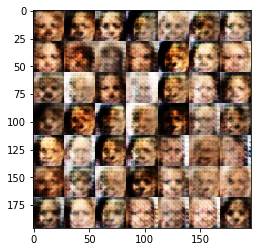

Epoch 1/1 Discriminator loss 1.0063 Generator loss 1.0354
Epoch 1/1 Discriminator loss 1.3545 Generator loss 0.9700
Epoch 1/1 Discriminator loss 1.0756 Generator loss 0.8602
Epoch 1/1 Discriminator loss 1.1558 Generator loss 1.1101
Epoch 1/1 Discriminator loss 1.2940 Generator loss 0.9469
Epoch 1/1 Discriminator loss 1.0261 Generator loss 1.5498
Epoch 1/1 Discriminator loss 1.2260 Generator loss 1.3440
Epoch 1/1 Discriminator loss 1.1730 Generator loss 0.9803
Epoch 1/1 Discriminator loss 1.2654 Generator loss 1.0486
Epoch 1/1 Discriminator loss 1.1009 Generator loss 0.9285
(?, 28, 28, 3)


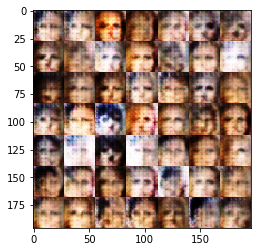

Epoch 1/1 Discriminator loss 1.4241 Generator loss 1.1701
Epoch 1/1 Discriminator loss 1.4875 Generator loss 0.7617
Epoch 1/1 Discriminator loss 1.1105 Generator loss 0.8828
Epoch 1/1 Discriminator loss 1.2985 Generator loss 1.1233
Epoch 1/1 Discriminator loss 1.2094 Generator loss 1.3885
Epoch 1/1 Discriminator loss 1.0783 Generator loss 1.1262
Epoch 1/1 Discriminator loss 1.2091 Generator loss 1.1786
Epoch 1/1 Discriminator loss 1.2877 Generator loss 1.1648
Epoch 1/1 Discriminator loss 1.1245 Generator loss 0.9124
Epoch 1/1 Discriminator loss 1.1522 Generator loss 1.0277
(?, 28, 28, 3)


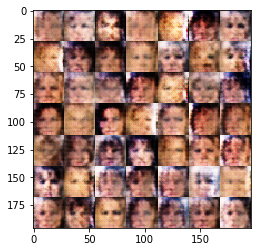

Epoch 1/1 Discriminator loss 1.0627 Generator loss 1.1629
Epoch 1/1 Discriminator loss 1.5041 Generator loss 0.8102
Epoch 1/1 Discriminator loss 1.1036 Generator loss 1.0828
Epoch 1/1 Discriminator loss 1.3059 Generator loss 0.9070
Epoch 1/1 Discriminator loss 1.1781 Generator loss 0.9774
Epoch 1/1 Discriminator loss 1.3199 Generator loss 1.0758
Epoch 1/1 Discriminator loss 1.2124 Generator loss 0.9000
Epoch 1/1 Discriminator loss 1.1247 Generator loss 0.9447
Epoch 1/1 Discriminator loss 1.2537 Generator loss 1.2020
Epoch 1/1 Discriminator loss 1.2879 Generator loss 1.1810
(?, 28, 28, 3)


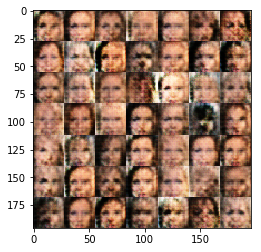

Epoch 1/1 Discriminator loss 1.2453 Generator loss 0.9424
Epoch 1/1 Discriminator loss 1.2263 Generator loss 1.1755
Epoch 1/1 Discriminator loss 1.0395 Generator loss 1.1562
Epoch 1/1 Discriminator loss 1.1293 Generator loss 1.0790
Epoch 1/1 Discriminator loss 1.0497 Generator loss 0.9690
Epoch 1/1 Discriminator loss 1.2265 Generator loss 1.1480
Epoch 1/1 Discriminator loss 1.0607 Generator loss 1.1808
Epoch 1/1 Discriminator loss 1.2974 Generator loss 1.3542
Epoch 1/1 Discriminator loss 1.1124 Generator loss 1.6472
Epoch 1/1 Discriminator loss 1.3772 Generator loss 0.9976
(?, 28, 28, 3)


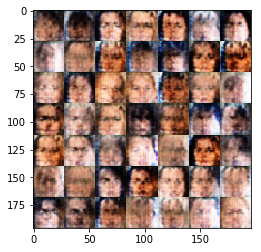

Epoch 1/1 Discriminator loss 0.9605 Generator loss 1.0856
Epoch 1/1 Discriminator loss 1.2664 Generator loss 0.8545
Epoch 1/1 Discriminator loss 1.2979 Generator loss 0.8995
Epoch 1/1 Discriminator loss 1.1290 Generator loss 0.9261
Epoch 1/1 Discriminator loss 1.3147 Generator loss 1.1675
Epoch 1/1 Discriminator loss 1.3277 Generator loss 1.0248
Epoch 1/1 Discriminator loss 1.1368 Generator loss 1.1510
Epoch 1/1 Discriminator loss 1.1584 Generator loss 1.0653
Epoch 1/1 Discriminator loss 1.1264 Generator loss 1.2438
Epoch 1/1 Discriminator loss 1.1752 Generator loss 1.0362
(?, 28, 28, 3)


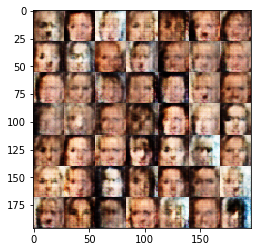

Epoch 1/1 Discriminator loss 1.0629 Generator loss 1.0976
Epoch 1/1 Discriminator loss 1.2002 Generator loss 1.1984
Epoch 1/1 Discriminator loss 1.1821 Generator loss 0.8530
Epoch 1/1 Discriminator loss 1.0965 Generator loss 0.9849
Epoch 1/1 Discriminator loss 1.1809 Generator loss 1.2420
Epoch 1/1 Discriminator loss 1.3582 Generator loss 0.7532
Epoch 1/1 Discriminator loss 1.2037 Generator loss 1.0406
Epoch 1/1 Discriminator loss 1.2044 Generator loss 1.2379
Epoch 1/1 Discriminator loss 1.1323 Generator loss 1.2377
Epoch 1/1 Discriminator loss 1.2196 Generator loss 0.8685
(?, 28, 28, 3)


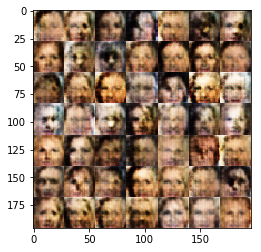

Epoch 1/1 Discriminator loss 1.3306 Generator loss 0.8054
Epoch 1/1 Discriminator loss 1.1493 Generator loss 0.9547
Epoch 1/1 Discriminator loss 1.3906 Generator loss 0.9878
Epoch 1/1 Discriminator loss 1.1988 Generator loss 1.2631
Epoch 1/1 Discriminator loss 1.5103 Generator loss 0.7629
Epoch 1/1 Discriminator loss 1.0241 Generator loss 1.0778
Epoch 1/1 Discriminator loss 1.0661 Generator loss 1.0178
Epoch 1/1 Discriminator loss 1.2473 Generator loss 0.8107
Epoch 1/1 Discriminator loss 1.0705 Generator loss 1.1009
Epoch 1/1 Discriminator loss 1.2344 Generator loss 1.1888
(?, 28, 28, 3)


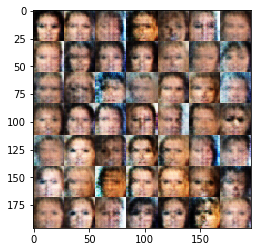

Epoch 1/1 Discriminator loss 1.2576 Generator loss 0.9152
Epoch 1/1 Discriminator loss 1.1331 Generator loss 0.9646
Epoch 1/1 Discriminator loss 1.1002 Generator loss 1.0401
Epoch 1/1 Discriminator loss 1.3412 Generator loss 1.0955
Epoch 1/1 Discriminator loss 1.4565 Generator loss 0.8467
Epoch 1/1 Discriminator loss 1.2847 Generator loss 1.1126
Epoch 1/1 Discriminator loss 1.3453 Generator loss 0.9218
Epoch 1/1 Discriminator loss 1.2642 Generator loss 0.8110
Epoch 1/1 Discriminator loss 1.2948 Generator loss 0.7056
Epoch 1/1 Discriminator loss 1.1157 Generator loss 1.0113
(?, 28, 28, 3)


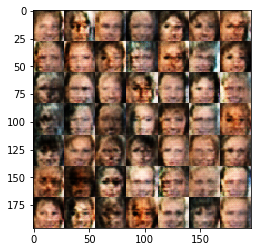

Epoch 1/1 Discriminator loss 1.2884 Generator loss 0.8829
Epoch 1/1 Discriminator loss 1.2578 Generator loss 0.8944
Epoch 1/1 Discriminator loss 1.0918 Generator loss 1.1953
Epoch 1/1 Discriminator loss 1.2834 Generator loss 0.9630
Epoch 1/1 Discriminator loss 1.1565 Generator loss 1.1440
Epoch 1/1 Discriminator loss 1.1921 Generator loss 1.0869
Epoch 1/1 Discriminator loss 1.2994 Generator loss 0.8236
Epoch 1/1 Discriminator loss 1.1814 Generator loss 0.9126
Epoch 1/1 Discriminator loss 1.4860 Generator loss 1.1281
Epoch 1/1 Discriminator loss 1.2043 Generator loss 1.0991
(?, 28, 28, 3)


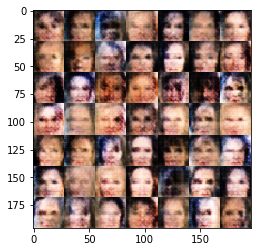

Epoch 1/1 Discriminator loss 1.0169 Generator loss 1.0689
Epoch 1/1 Discriminator loss 1.1430 Generator loss 1.2231
Epoch 1/1 Discriminator loss 1.2272 Generator loss 1.0178
Epoch 1/1 Discriminator loss 1.3658 Generator loss 1.0646
Epoch 1/1 Discriminator loss 1.2553 Generator loss 0.8549
Epoch 1/1 Discriminator loss 1.2225 Generator loss 0.9334
Epoch 1/1 Discriminator loss 1.0548 Generator loss 1.4349
Epoch 1/1 Discriminator loss 1.2736 Generator loss 0.9355
Epoch 1/1 Discriminator loss 1.0263 Generator loss 1.2238
Epoch 1/1 Discriminator loss 1.1663 Generator loss 1.0286
(?, 28, 28, 3)


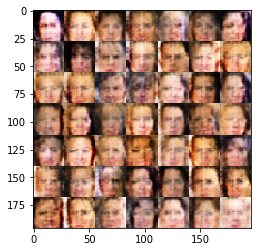

Epoch 1/1 Discriminator loss 1.3887 Generator loss 0.9093
Epoch 1/1 Discriminator loss 1.1752 Generator loss 1.2575
Epoch 1/1 Discriminator loss 1.0474 Generator loss 1.0887
Epoch 1/1 Discriminator loss 1.2596 Generator loss 0.8918
Epoch 1/1 Discriminator loss 1.2378 Generator loss 0.8001
Epoch 1/1 Discriminator loss 1.0778 Generator loss 1.0550
Epoch 1/1 Discriminator loss 0.9620 Generator loss 1.1594
Epoch 1/1 Discriminator loss 1.1099 Generator loss 0.8834
Epoch 1/1 Discriminator loss 1.2622 Generator loss 0.8551
Epoch 1/1 Discriminator loss 1.1970 Generator loss 1.0520
(?, 28, 28, 3)


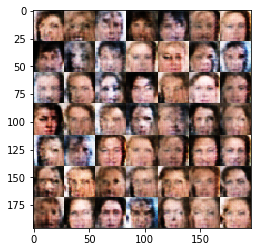

Epoch 1/1 Discriminator loss 1.3176 Generator loss 1.0780
Epoch 1/1 Discriminator loss 1.0706 Generator loss 1.0360
Epoch 1/1 Discriminator loss 1.2004 Generator loss 0.8184
Epoch 1/1 Discriminator loss 1.1443 Generator loss 1.0011
Epoch 1/1 Discriminator loss 0.9965 Generator loss 1.0824
Epoch 1/1 Discriminator loss 1.3397 Generator loss 0.7926
Epoch 1/1 Discriminator loss 1.3205 Generator loss 0.9012
Epoch 1/1 Discriminator loss 1.2167 Generator loss 0.9490
Epoch 1/1 Discriminator loss 1.1881 Generator loss 0.7417
Epoch 1/1 Discriminator loss 0.9123 Generator loss 1.1285
(?, 28, 28, 3)


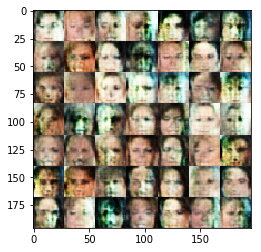

Epoch 1/1 Discriminator loss 1.0279 Generator loss 1.0160
Epoch 1/1 Discriminator loss 1.1230 Generator loss 1.0230
Epoch 1/1 Discriminator loss 0.9489 Generator loss 1.2909
Epoch 1/1 Discriminator loss 1.3049 Generator loss 0.8433
Epoch 1/1 Discriminator loss 1.0199 Generator loss 1.1696
Epoch 1/1 Discriminator loss 1.3391 Generator loss 1.0926
Epoch 1/1 Discriminator loss 1.0803 Generator loss 1.0010
Epoch 1/1 Discriminator loss 1.2064 Generator loss 0.9417
Epoch 1/1 Discriminator loss 1.3426 Generator loss 0.8515
Epoch 1/1 Discriminator loss 1.0469 Generator loss 1.1976
(?, 28, 28, 3)


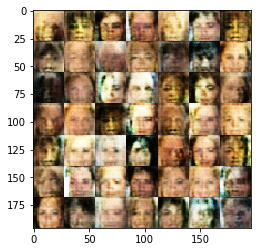

Epoch 1/1 Discriminator loss 1.2967 Generator loss 0.9323
Epoch 1/1 Discriminator loss 1.1531 Generator loss 1.1972
Epoch 1/1 Discriminator loss 1.0641 Generator loss 1.1794
Epoch 1/1 Discriminator loss 1.0619 Generator loss 1.0347
Epoch 1/1 Discriminator loss 1.1913 Generator loss 1.1295
Epoch 1/1 Discriminator loss 1.2514 Generator loss 0.9045
Epoch 1/1 Discriminator loss 1.2612 Generator loss 1.0518
Epoch 1/1 Discriminator loss 1.1801 Generator loss 0.8730
Epoch 1/1 Discriminator loss 1.2769 Generator loss 1.1648
Epoch 1/1 Discriminator loss 1.2795 Generator loss 0.9488
(?, 28, 28, 3)


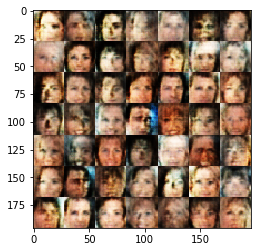

Epoch 1/1 Discriminator loss 1.1479 Generator loss 1.0686
Epoch 1/1 Discriminator loss 1.2588 Generator loss 0.9577
Epoch 1/1 Discriminator loss 1.2008 Generator loss 1.0978
Epoch 1/1 Discriminator loss 1.1762 Generator loss 1.0309
Epoch 1/1 Discriminator loss 1.4105 Generator loss 0.9952
Epoch 1/1 Discriminator loss 1.1183 Generator loss 1.1687
Epoch 1/1 Discriminator loss 1.3735 Generator loss 0.8838
Epoch 1/1 Discriminator loss 1.2494 Generator loss 1.1489
Epoch 1/1 Discriminator loss 1.3505 Generator loss 0.9098
Epoch 1/1 Discriminator loss 1.3818 Generator loss 1.0574
(?, 28, 28, 3)


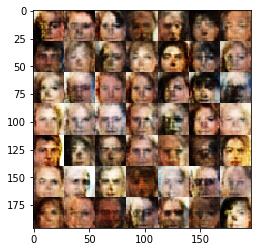

Epoch 1/1 Discriminator loss 1.2994 Generator loss 0.7916
Epoch 1/1 Discriminator loss 1.1069 Generator loss 1.1421
Epoch 1/1 Discriminator loss 1.2409 Generator loss 0.9331
Epoch 1/1 Discriminator loss 0.9541 Generator loss 0.9963
Epoch 1/1 Discriminator loss 1.1637 Generator loss 1.0000
Epoch 1/1 Discriminator loss 1.2088 Generator loss 1.1246
Epoch 1/1 Discriminator loss 1.3252 Generator loss 0.7524
Epoch 1/1 Discriminator loss 1.3437 Generator loss 1.0503
Epoch 1/1 Discriminator loss 1.0496 Generator loss 1.0648
Epoch 1/1 Discriminator loss 1.2652 Generator loss 1.0072
(?, 28, 28, 3)


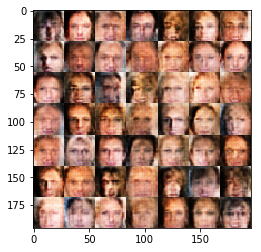

Epoch 1/1 Discriminator loss 1.1798 Generator loss 1.0179
Epoch 1/1 Discriminator loss 1.3065 Generator loss 1.0588
Epoch 1/1 Discriminator loss 1.1670 Generator loss 0.9920
Epoch 1/1 Discriminator loss 1.2527 Generator loss 0.9036
Epoch 1/1 Discriminator loss 1.3899 Generator loss 0.8371
Epoch 1/1 Discriminator loss 1.2331 Generator loss 1.1342
Epoch 1/1 Discriminator loss 1.2203 Generator loss 0.8963
Epoch 1/1 Discriminator loss 1.3044 Generator loss 0.9381
Epoch 1/1 Discriminator loss 1.2554 Generator loss 0.9493
Epoch 1/1 Discriminator loss 1.1575 Generator loss 1.0752
(?, 28, 28, 3)


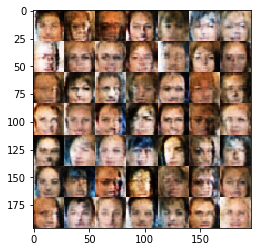

Epoch 1/1 Discriminator loss 1.0885 Generator loss 1.0419
Epoch 1/1 Discriminator loss 1.0840 Generator loss 1.2846
Epoch 1/1 Discriminator loss 1.2458 Generator loss 0.8850
Epoch 1/1 Discriminator loss 1.3796 Generator loss 1.2206
Epoch 1/1 Discriminator loss 1.3216 Generator loss 0.8086
Epoch 1/1 Discriminator loss 1.1971 Generator loss 1.1909
Epoch 1/1 Discriminator loss 1.2227 Generator loss 1.0902
Epoch 1/1 Discriminator loss 1.3024 Generator loss 0.8343
Epoch 1/1 Discriminator loss 1.1003 Generator loss 1.0016
Epoch 1/1 Discriminator loss 1.3194 Generator loss 0.9225
(?, 28, 28, 3)


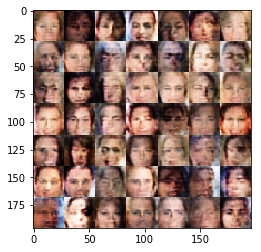

Epoch 1/1 Discriminator loss 1.1744 Generator loss 1.2016
Epoch 1/1 Discriminator loss 1.1331 Generator loss 1.0185
Epoch 1/1 Discriminator loss 1.1834 Generator loss 1.2793
Epoch 1/1 Discriminator loss 1.4819 Generator loss 0.7677
Epoch 1/1 Discriminator loss 1.3216 Generator loss 0.7162
Epoch 1/1 Discriminator loss 1.1134 Generator loss 1.0121
Epoch 1/1 Discriminator loss 1.0325 Generator loss 1.0749
Epoch 1/1 Discriminator loss 1.3911 Generator loss 0.7857
Epoch 1/1 Discriminator loss 1.3352 Generator loss 0.9194
Epoch 1/1 Discriminator loss 1.2390 Generator loss 0.9249
(?, 28, 28, 3)


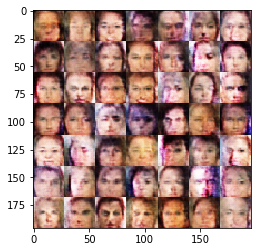

Epoch 1/1 Discriminator loss 1.1627 Generator loss 1.0972
Epoch 1/1 Discriminator loss 1.1826 Generator loss 1.0462
Epoch 1/1 Discriminator loss 1.1286 Generator loss 1.0529
Epoch 1/1 Discriminator loss 1.2448 Generator loss 0.9871
Epoch 1/1 Discriminator loss 1.3128 Generator loss 0.8138
Epoch 1/1 Discriminator loss 1.3358 Generator loss 0.9105
Epoch 1/1 Discriminator loss 1.2338 Generator loss 0.8148
Epoch 1/1 Discriminator loss 1.2135 Generator loss 0.7940
Epoch 1/1 Discriminator loss 1.2271 Generator loss 1.2843
Epoch 1/1 Discriminator loss 1.1311 Generator loss 1.3901
(?, 28, 28, 3)


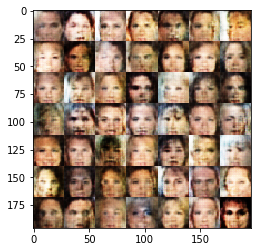

Epoch 1/1 Discriminator loss 1.1063 Generator loss 0.8836
Epoch 1/1 Discriminator loss 1.2612 Generator loss 1.0954
Epoch 1/1 Discriminator loss 1.2504 Generator loss 0.9698
Epoch 1/1 Discriminator loss 1.2158 Generator loss 1.1257
Epoch 1/1 Discriminator loss 1.2763 Generator loss 0.8099
Epoch 1/1 Discriminator loss 1.1280 Generator loss 0.9341
Epoch 1/1 Discriminator loss 1.1623 Generator loss 1.0371
Epoch 1/1 Discriminator loss 1.3276 Generator loss 1.0175
Epoch 1/1 Discriminator loss 1.2283 Generator loss 1.0812
Epoch 1/1 Discriminator loss 1.1690 Generator loss 0.9464
(?, 28, 28, 3)


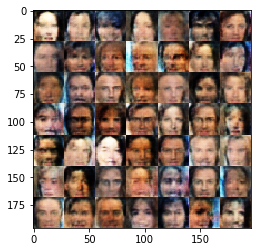

Epoch 1/1 Discriminator loss 1.2580 Generator loss 1.0711
Epoch 1/1 Discriminator loss 1.2558 Generator loss 0.7625
Epoch 1/1 Discriminator loss 1.2303 Generator loss 0.8928
Epoch 1/1 Discriminator loss 1.1491 Generator loss 0.8170
Epoch 1/1 Discriminator loss 1.2858 Generator loss 0.9737
Epoch 1/1 Discriminator loss 1.3909 Generator loss 0.9618
Epoch 1/1 Discriminator loss 1.2793 Generator loss 0.9137
Epoch 1/1 Discriminator loss 1.2076 Generator loss 1.0001
Epoch 1/1 Discriminator loss 1.2299 Generator loss 0.8238
Epoch 1/1 Discriminator loss 1.3230 Generator loss 0.9570
(?, 28, 28, 3)


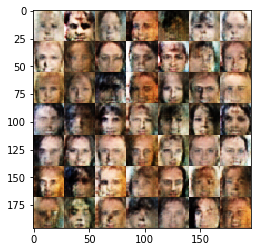

Epoch 1/1 Discriminator loss 1.2858 Generator loss 0.9431
Epoch 1/1 Discriminator loss 1.2733 Generator loss 1.0159
Epoch 1/1 Discriminator loss 1.1778 Generator loss 1.0024
Epoch 1/1 Discriminator loss 1.2161 Generator loss 0.7881
Epoch 1/1 Discriminator loss 1.1350 Generator loss 0.9925
Epoch 1/1 Discriminator loss 1.3262 Generator loss 0.9878
Epoch 1/1 Discriminator loss 1.1669 Generator loss 0.9490
Epoch 1/1 Discriminator loss 1.3126 Generator loss 0.7967
Epoch 1/1 Discriminator loss 1.0516 Generator loss 1.0364
Epoch 1/1 Discriminator loss 1.3461 Generator loss 0.8028
(?, 28, 28, 3)


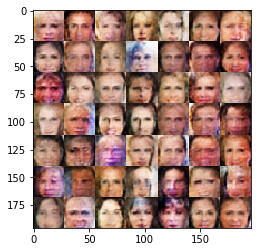

Epoch 1/1 Discriminator loss 1.1691 Generator loss 1.0160
Epoch 1/1 Discriminator loss 1.2904 Generator loss 0.8825
Epoch 1/1 Discriminator loss 1.1203 Generator loss 1.3626
Epoch 1/1 Discriminator loss 1.1788 Generator loss 0.9144
Epoch 1/1 Discriminator loss 1.2793 Generator loss 1.0475
Epoch 1/1 Discriminator loss 1.3264 Generator loss 0.6829
Epoch 1/1 Discriminator loss 1.2781 Generator loss 0.7690
Epoch 1/1 Discriminator loss 1.3193 Generator loss 0.8200
Epoch 1/1 Discriminator loss 1.2015 Generator loss 1.0468
Epoch 1/1 Discriminator loss 1.2703 Generator loss 0.8437
(?, 28, 28, 3)


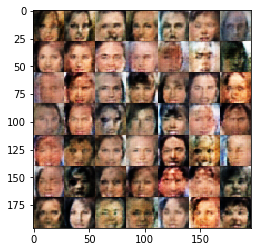

Epoch 1/1 Discriminator loss 1.3989 Generator loss 0.8173
Epoch 1/1 Discriminator loss 1.3137 Generator loss 0.8564
Epoch 1/1 Discriminator loss 1.3481 Generator loss 0.8542
Epoch 1/1 Discriminator loss 1.4051 Generator loss 0.7682
Epoch 1/1 Discriminator loss 1.1372 Generator loss 1.0258
Epoch 1/1 Discriminator loss 1.2363 Generator loss 0.9436
Epoch 1/1 Discriminator loss 1.3773 Generator loss 0.8932
Epoch 1/1 Discriminator loss 1.3515 Generator loss 1.0373
Epoch 1/1 Discriminator loss 1.2133 Generator loss 0.7889
Epoch 1/1 Discriminator loss 1.2359 Generator loss 0.9749
(?, 28, 28, 3)


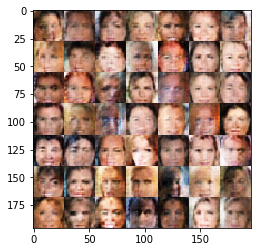

Epoch 1/1 Discriminator loss 1.2330 Generator loss 0.8507
Epoch 1/1 Discriminator loss 1.2155 Generator loss 0.9279
Epoch 1/1 Discriminator loss 1.1343 Generator loss 0.8194
Epoch 1/1 Discriminator loss 1.4046 Generator loss 0.7817
Epoch 1/1 Discriminator loss 1.4583 Generator loss 0.9155
Epoch 1/1 Discriminator loss 1.2248 Generator loss 0.7870
Epoch 1/1 Discriminator loss 1.1702 Generator loss 1.2037
Epoch 1/1 Discriminator loss 1.1286 Generator loss 0.9861
Epoch 1/1 Discriminator loss 1.3905 Generator loss 0.8088
Epoch 1/1 Discriminator loss 1.3931 Generator loss 0.9718
(?, 28, 28, 3)


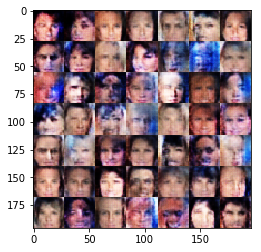

Epoch 1/1 Discriminator loss 1.1147 Generator loss 1.1592
Epoch 1/1 Discriminator loss 1.1973 Generator loss 0.9767
Epoch 1/1 Discriminator loss 1.3156 Generator loss 0.8079
Epoch 1/1 Discriminator loss 1.2352 Generator loss 1.0647
Epoch 1/1 Discriminator loss 1.1892 Generator loss 0.8763
Epoch 1/1 Discriminator loss 1.4119 Generator loss 0.9951
Epoch 1/1 Discriminator loss 1.1586 Generator loss 0.9487
Epoch 1/1 Discriminator loss 1.2811 Generator loss 0.9979
Epoch 1/1 Discriminator loss 1.3194 Generator loss 0.9149
Epoch 1/1 Discriminator loss 1.3899 Generator loss 0.8016
(?, 28, 28, 3)


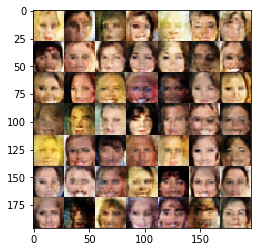

Epoch 1/1 Discriminator loss 1.1656 Generator loss 0.9392
Epoch 1/1 Discriminator loss 1.2662 Generator loss 0.9817
Epoch 1/1 Discriminator loss 1.1849 Generator loss 1.0289
Epoch 1/1 Discriminator loss 1.2481 Generator loss 1.0542
Epoch 1/1 Discriminator loss 1.1835 Generator loss 0.9757
Epoch 1/1 Discriminator loss 1.3365 Generator loss 0.9632
Epoch 1/1 Discriminator loss 1.1645 Generator loss 0.9124
Epoch 1/1 Discriminator loss 1.3507 Generator loss 0.7588
Epoch 1/1 Discriminator loss 1.5153 Generator loss 0.7712
Epoch 1/1 Discriminator loss 1.1901 Generator loss 0.9621
(?, 28, 28, 3)


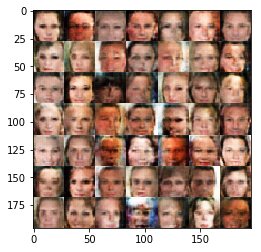

Epoch 1/1 Discriminator loss 1.2779 Generator loss 0.8883
Epoch 1/1 Discriminator loss 1.3598 Generator loss 1.1453
Epoch 1/1 Discriminator loss 1.3322 Generator loss 0.8481
Epoch 1/1 Discriminator loss 1.2955 Generator loss 0.8429
Epoch 1/1 Discriminator loss 1.1966 Generator loss 0.9124
Epoch 1/1 Discriminator loss 1.4041 Generator loss 0.9104
Epoch 1/1 Discriminator loss 1.2007 Generator loss 1.0843
Epoch 1/1 Discriminator loss 1.3205 Generator loss 0.8714
Epoch 1/1 Discriminator loss 1.3531 Generator loss 1.0214
Epoch 1/1 Discriminator loss 1.3149 Generator loss 0.9503
(?, 28, 28, 3)


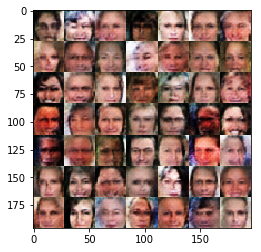

Epoch 1/1 Discriminator loss 1.0356 Generator loss 1.1900
Epoch 1/1 Discriminator loss 1.3879 Generator loss 0.9114
Epoch 1/1 Discriminator loss 1.3230 Generator loss 0.7393
Epoch 1/1 Discriminator loss 1.3402 Generator loss 0.7532
Epoch 1/1 Discriminator loss 1.1830 Generator loss 0.9772
Epoch 1/1 Discriminator loss 1.4277 Generator loss 0.5974
Epoch 1/1 Discriminator loss 1.3046 Generator loss 0.8582
Epoch 1/1 Discriminator loss 1.1983 Generator loss 1.0118
Epoch 1/1 Discriminator loss 1.3245 Generator loss 0.7986
Epoch 1/1 Discriminator loss 1.4394 Generator loss 0.9350
(?, 28, 28, 3)


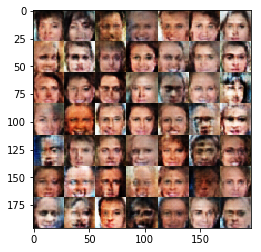

Epoch 1/1 Discriminator loss 1.2598 Generator loss 0.8442
Epoch 1/1 Discriminator loss 1.2541 Generator loss 1.0037
Epoch 1/1 Discriminator loss 1.2294 Generator loss 0.9545
Epoch 1/1 Discriminator loss 1.2983 Generator loss 0.8303
Epoch 1/1 Discriminator loss 1.2382 Generator loss 0.8130
Epoch 1/1 Discriminator loss 1.3027 Generator loss 0.8210
Epoch 1/1 Discriminator loss 1.2870 Generator loss 1.0420
Epoch 1/1 Discriminator loss 1.3844 Generator loss 0.8471
Epoch 1/1 Discriminator loss 1.2896 Generator loss 0.9469
Epoch 1/1 Discriminator loss 1.3182 Generator loss 0.9269
(?, 28, 28, 3)


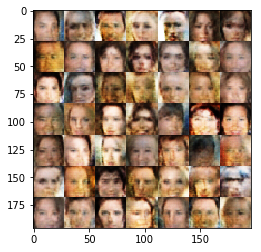

Epoch 1/1 Discriminator loss 1.2585 Generator loss 0.7679
Epoch 1/1 Discriminator loss 1.1905 Generator loss 1.1947
Epoch 1/1 Discriminator loss 1.2380 Generator loss 0.9360
Epoch 1/1 Discriminator loss 1.2693 Generator loss 0.8257
Epoch 1/1 Discriminator loss 1.3090 Generator loss 0.8957
Epoch 1/1 Discriminator loss 1.1256 Generator loss 0.9317
Epoch 1/1 Discriminator loss 1.2282 Generator loss 0.8885
Epoch 1/1 Discriminator loss 1.2284 Generator loss 0.7888
Epoch 1/1 Discriminator loss 1.2069 Generator loss 0.9601
Epoch 1/1 Discriminator loss 1.2385 Generator loss 0.8803
(?, 28, 28, 3)


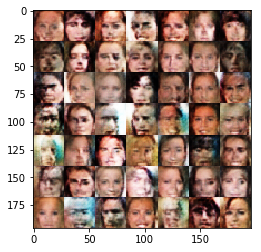

Epoch 1/1 Discriminator loss 1.3860 Generator loss 0.8877
Epoch 1/1 Discriminator loss 1.2820 Generator loss 0.9041
Epoch 1/1 Discriminator loss 1.2223 Generator loss 1.0601
Epoch 1/1 Discriminator loss 1.2734 Generator loss 0.7130
Epoch 1/1 Discriminator loss 1.2377 Generator loss 0.8712
Epoch 1/1 Discriminator loss 1.2974 Generator loss 0.9833
Epoch 1/1 Discriminator loss 1.3490 Generator loss 0.8365
Epoch 1/1 Discriminator loss 1.3518 Generator loss 0.7973
Epoch 1/1 Discriminator loss 1.3501 Generator loss 0.8418
Epoch 1/1 Discriminator loss 1.3978 Generator loss 0.7261
(?, 28, 28, 3)


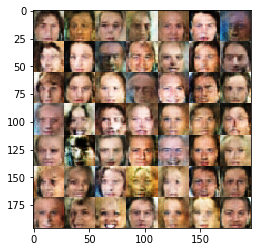

KeyboardInterrupt: 

In [13]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5
epochs = 1
# ~20 minutes for typical GPU to run one epoch

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)
    
# If cost of GPU time is an issue, the GAN can be paused prematurely when the faces look realistic enough.